In [236]:
# Author: Hogan Lin
# Date: Nov 05th 2024
# Github: https://github.com/hogan-tech/SIT/blob/main/AppliedMachineLearning/HW4/HW4.ipynb

1. In this programming problem, you will get familiar with building a neural network using
backpropagation. 
2. You will write a program that learns how to recognize the handwritten digits using
stochastic gradient descent and the MNIST training data.
3. The MNIST database (Modified National Institute of Standards and Technology database is a large
database of handwritten digits that is commonly used for training various image processing systems

## Observations
1. Data Loading and Preprocessing: The dataset is successfully loaded using a function that handles IDX files and the images are normalized, an essential step to improve network training.

2. One-hot Encoding: Labels are one-hot encoded, allowing for multi-class classification using cross-entropy loss.

3. Model Architecture: The network has two hidden layers with 128 and 64 units respectively, followed by an output layer of 10 units. Sigmoid is used as the activation function for hidden layers, and softmax is used for the output layer, appropriate for classification.

4. Training: The network uses mini-batch gradient descent with batch size 128 and an epoch loop that shuffles the data each iteration. A learning rate of 0.01 is used.


## Step 1 Data Acquisition and Visualization (10 pts): 
In this step, you need to:
1. Download the “MNIST” dataset and extract the files. You will get four files with extension .gz (e.g., train-images-idx3-ubyte.gz). You can use the provided function read_idx below to read in the dataset. As its official description, the dataset is split into 60000 training images and 10000 images. The four file corresponds to the training images, training labels, testing images and testing labels. You need to print out their shape to finish this step. (5 pts)

In [237]:
# Import necessary libraries
import struct
import numpy as np
import gzip

# Provided function to read IDX files, this is HW4 document example code
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# Load the dataset files
train_images = read_idx('./train-images-idx3-ubyte.gz')
train_labels = read_idx('./train-labels-idx1-ubyte.gz')
test_images = read_idx('./t10k-images-idx3-ubyte.gz')
test_labels = read_idx('./t10k-labels-idx1-ubyte.gz')

# Print shapes of data arrays
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Testing images shape: {test_images.shape}")
print(f"Testing labels shape: {test_labels.shape}")

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Testing images shape: (10000, 28, 28)
Testing labels shape: (10000,)


2. To further understand what the dataset is, you need to use the ‘matplotlib’ library to print out a random data with code plt.imshow together with its label.(5 pts) You will see something like this:

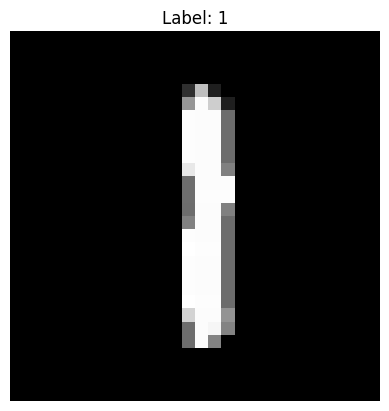

In [238]:
# Import the necessary library
import matplotlib.pyplot as plt

# Select a random index to display an image
random_index = np.random.randint(0, train_images.shape[0])

# Retrieve the image and label for the random index
image = train_images[random_index]
label = train_labels[random_index]

# Plot the image with matplotlib
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')  # Hide the axes for a cleaner look
plt.show()


## Step 2 Data Preprocessing (10 pts): 
In this step, you need to:
1. Normalize the pixel values of images to be between 0 and 1. (5 pts)
2. Convert the labels from categorical data into numerical values using one-hot encoding. (5 pts)
hint: you can explore the eye function in Numpy.

In [239]:
# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# One-hot encode labels
num_classes = 10
train_labels_onehot = np.eye(num_classes)[train_labels]
test_labels_onehot = np.eye(num_classes)[test_labels]

print("train_labels_onehot: ", train_labels_onehot)
print("test_labels_onehot: ", test_labels_onehot)

train_labels_onehot:  [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
test_labels_onehot:  [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Step 3 Network Initialization (10 pts): 
We will work with a neuron network with two hidden layers, using Sigmoid function as the activation functions for hidden layers and softmax activation function for the output layer. To finish this, you need to:

1. Identify the auxiliary input including the Sigmoid function and its derivative and Softmax function



In [240]:
# Set random seed for reproducibility, 20035085 is my student ID
np.random.seed(20035085) 

# Define Sigmoid and Softmax functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

2. Initialize all the parameters in neural network uniformly. In this network, the input size is 784 dimensions (each input is a 28x28 image, so you have to flatten the data from 2D to 1D). For the two linear hidden layers, we have 128 and 64 neurons respectively. For the output layer, its size will be 10 since there are 10 classes (0-9) in MNIST. To finish this step, you need to initialize the weights and bias in random with a pre-set random seed using Numpy. Please set the seed value = 695. (5 pts)

In [241]:
# Network parameters
input_size = 784
hidden_layer1_size = 128
hidden_layer2_size = 64
output_size = 10

# Initialize weights and biases
weights1 = np.random.uniform(-0.1, 0.1, (input_size, hidden_layer1_size))
bias1 = np.zeros((1, hidden_layer1_size))
weights2 = np.random.uniform(-0.1, 0.1, (hidden_layer1_size, hidden_layer2_size))
bias2 = np.zeros((1, hidden_layer2_size))
weights3 = np.random.uniform(-0.1, 0.1, (hidden_layer2_size, output_size))
bias3 = np.zeros((1, output_size))


## Step 4 Feed Forward (10 pts): 
In this step, you need to:
1. Define a function named feed_forward. Given an input x, it should output the sigmoid of wx+b where w and b indicates the weights and bias defined in step 2. (5 pts)

In [242]:
def feed_forward(x):
    layer1 = sigmoid(np.dot(x, weights1) + bias1)
    layer2 = sigmoid(np.dot(layer1, weights2) + bias2)
    output_layer = softmax(np.dot(layer2, weights3) + bias3)
    return layer1, layer2, output_layer


## Step 5 Back Propagation (15 pts): 
In this step, you need to implement the back propagation:
1. You need to compute the loss for the output layer first. Here, we use categorical cross entropy
loss function given below for multi-class classification problem. (5 pts) Note, to achieve this, you
need to first encode the categorical labels as numerical values using one-hot encoding finished
in step 2. (5 pts)

In [243]:
# This is the code example from the HW4 document
def categorical_crossentropy(y_true, y_pred):
    # Number of samples
    n_samples = y_true.shape[0]
    # Clip predictions to avoid log(0) errors
    y_pred_clipped = np.clip(y_pred, 1e-12, 1 - 1e-12)
    # Compute cross-entropy loss
    return -np.sum(y_true * np.log(y_pred_clipped)) / n_samples


In [244]:
def backpropagation(x, y_true, layer1, layer2, output_layer):
    # Number of samples
    n_samples = y_true.shape[0]
    
    # Calculate error at output layer
    d_output = output_layer - y_true  # (output_layer - y_true) is the derivative of the cross-entropy loss
    grad_weights3 = np.dot(layer2.T, d_output) / n_samples
    grad_bias3 = np.sum(d_output, axis=0, keepdims=True) / n_samples

    # Calculate error for second hidden layer
    d_layer2 = np.dot(d_output, weights3.T) * sigmoid_derivative(layer2)
    grad_weights2 = np.dot(layer1.T, d_layer2) / n_samples
    grad_bias2 = np.sum(d_layer2, axis=0, keepdims=True) / n_samples

    # Calculate error for first hidden layer
    d_layer1 = np.dot(d_layer2, weights2.T) * sigmoid_derivative(layer1)
    grad_weights1 = np.dot(x.T, d_layer1) / n_samples
    grad_bias1 = np.sum(d_layer1, axis=0, keepdims=True) / n_samples

    # Return the gradients
    return grad_weights1, grad_bias1, grad_weights2, grad_bias2, grad_weights3, grad_bias3


## Step 6 Model Training (15 pts): 
In this step, you need to:
1. Use mini-batch gradient descent to update the parameters including weights and bias. Notice
that a complete training round consists of a feed forward process, back propagation and
parameter update. Define the batch size = 128 and epoch = 100.

## Reference

Mini-Batch Gradient Descent: Optimizing Machine Learning: 
https://medium.com/@juanc.olamendy/mini-batch-gradient-descent-optimizing-machine-learning-98ef238c5225

Training in mini-batches: Stochastic gradient descent:
https://github.com/parrt/msds621/blob/master/notebooks/deep-learning/7.SGD-minibatch-mnist.ipynb

In [245]:
# Hyperparameters
batch_size = 128
epochs = 100
learning_rate = 0.01


# Training loop
for epoch in range(epochs):
    # Shuffle the data
    indices = np.arange(train_images.shape[0])
    np.random.shuffle(indices)
    train_images = train_images[indices]
    train_labels = train_labels[indices]

    train_images = train_images.reshape(-1, 784)
    test_images = test_images.reshape(-1, 784)
    
    # # Mini-batch gradient descent
    for i in range(0, train_images.shape[0], batch_size):
        x_batch = train_images[i:i+batch_size]
        y_batch = train_labels_onehot[i:i+batch_size]

        # Feed forward
        layer1, layer2, output_layer = feed_forward(x_batch)

        # Compute loss (optional, for monitoring training)
        loss = categorical_crossentropy(y_batch, output_layer)

        # Backpropagation to calculate gradients
        grad_weights1, grad_bias1, grad_weights2, grad_bias2, grad_weights3, grad_bias3 = backpropagation(
            x_batch, y_batch, layer1, layer2, output_layer
        )

        # Update parameters
        weights1 -= learning_rate * grad_weights1
        bias1 -= learning_rate * grad_bias1
        weights2 -= learning_rate * grad_weights2
        bias2 -= learning_rate * grad_bias2
        weights3 -= learning_rate * grad_weights3
        bias3 -= learning_rate * grad_bias3

    # Optionally, print the loss to track the training progress
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")


Epoch 1/100, Loss: 2.3040
Epoch 2/100, Loss: 2.3041
Epoch 3/100, Loss: 2.3047
Epoch 4/100, Loss: 2.3038
Epoch 5/100, Loss: 2.3039
Epoch 6/100, Loss: 2.3039
Epoch 7/100, Loss: 2.3052
Epoch 8/100, Loss: 2.3043
Epoch 9/100, Loss: 2.3031
Epoch 10/100, Loss: 2.3034
Epoch 11/100, Loss: 2.3038
Epoch 12/100, Loss: 2.3054
Epoch 13/100, Loss: 2.3035
Epoch 14/100, Loss: 2.3044
Epoch 15/100, Loss: 2.3046
Epoch 16/100, Loss: 2.3042
Epoch 17/100, Loss: 2.3038
Epoch 18/100, Loss: 2.3040
Epoch 19/100, Loss: 2.3048
Epoch 20/100, Loss: 2.3049
Epoch 21/100, Loss: 2.3041
Epoch 22/100, Loss: 2.3036
Epoch 23/100, Loss: 2.3048
Epoch 24/100, Loss: 2.3043
Epoch 25/100, Loss: 2.3042
Epoch 26/100, Loss: 2.3056
Epoch 27/100, Loss: 2.3033
Epoch 28/100, Loss: 2.3049
Epoch 29/100, Loss: 2.3039
Epoch 30/100, Loss: 2.3030
Epoch 31/100, Loss: 2.3044
Epoch 32/100, Loss: 2.3045
Epoch 33/100, Loss: 2.3048
Epoch 34/100, Loss: 2.3047
Epoch 35/100, Loss: 2.3057
Epoch 36/100, Loss: 2.3043
Epoch 37/100, Loss: 2.3041
Epoch 38/1

## Step 7 Model Evaluation (10 pts): 
In this step, you need to:
1. Use your trained neural network to predict the labels of the test dataset and compute the
accuracy on the test dataset. (5 pts)

In [246]:
def predict(x):
    # Forward pass through the trained network
    layer1 = sigmoid(np.dot(x, weights1) + bias1)
    layer2 = sigmoid(np.dot(layer1, weights2) + bias2)
    output_layer = softmax(np.dot(layer2, weights3) + bias3)
    return np.argmax(output_layer, axis=1)

def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


# Get predictions for test images
y_test_pred = predict(test_images)
# Convert one-hot encoded test labels back to single integers
y_test_true = test_labels 

# Calculate accuracy
accuracy = compute_accuracy(y_test_true, y_test_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 13.01%


**A test accuracy of 13.01% indicates that the model correctly classifies the test images only about 13% of the time, which is very close to random guessing**

2. Plot some of the misclassified images with their predicted and true labels. (5 pts) This probably
can give you some insights into why these images are misclassified.

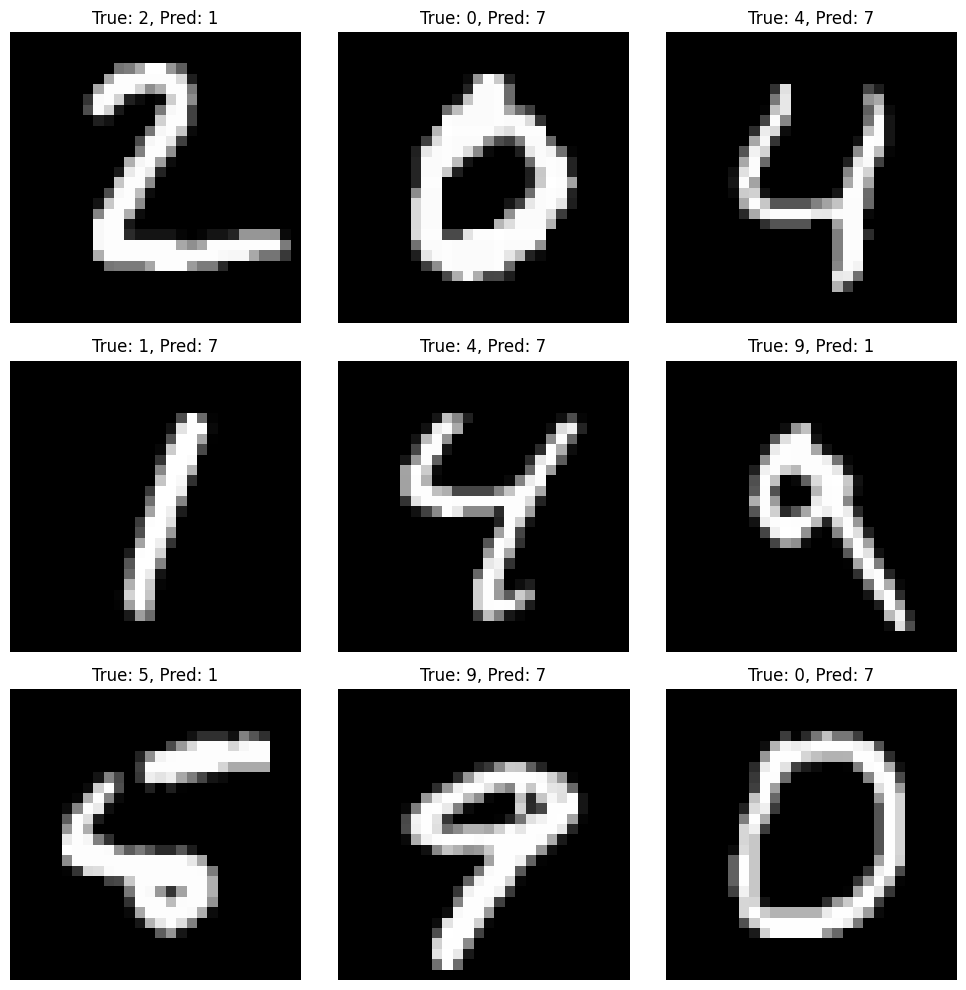

In [247]:
import matplotlib.pyplot as plt

# Identify misclassified images
misclassified_indices = np.where(y_test_pred != y_test_true)[0]

# Plot a few misclassified images
plt.figure(figsize=(10, 10))
for i, idx in enumerate(misclassified_indices[:9]):  # Display up to 9 misclassified images
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_test_true[idx]}, Pred: {y_test_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## Thoughts
1. Activation Function Choice: Sigmoid activation can lead to vanishing gradients, especially in deeper networks. ReLU (Rectified Linear Unit) is often more effective for hidden layers as it reduces gradient issues and accelerates convergence.

2. Loss Behavior: The loss values shared indicate that the model may be underfitting, as it oscillates around 2.3, close to random guessing (e.g., 1/10 for ten classes). This suggests that the model isn't learning effectively with the current setup, potentially due to activation function choice, weight initialization, or learning rate.

3. Accuracy Calculation: Implementing accuracy as a metric for the test set is effective for gauging generalization.


## Insights 

1. Consider Activation Adjustments: Switching from Sigmoid to ReLU in the hidden layers could help with gradient flow and overall convergence, particularly given the depth of your network.

2. Evaluate Weight Initialization: Initializing weights with small values close to zero could cause gradient issues. Using a more advanced initialization, like He or Xavier initialization, might improve training stability and speed.

3. Learning Rate Tuning: If the loss remains unchanged, we might explore a slightly higher or lower learning rate. Using learning rate decay can also prevent oscillations in later stages of training.

4. Accuracy Monitoring per Epoch: Adding a quick accuracy calculation for the training set per epoch can offer more insight into whether the model is effectively learning the patterns in the data.

## Improve

Although we do not need to improve the accurancy, but I did the Keras CNN Mnist several years ago, here is the quick implementation, and the accuracy improve from 13.04% to 98%.

In [250]:
import numpy as np
import struct
import gzip
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Load IDX files (this remains the same as before)
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# Load dataset
train_images = read_idx('./train-images-idx3-ubyte.gz')
train_labels = read_idx('./train-labels-idx1-ubyte.gz')
test_images = read_idx('./t10k-images-idx3-ubyte.gz')
test_labels = read_idx('./t10k-labels-idx1-ubyte.gz')

# Normalize and reshape images to match CNN input (add channel dimension)
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))

# One-hot encode labels
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels))

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/10


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8501 - loss: 0.5114 - val_accuracy: 0.9776 - val_loss: 0.0748
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9797 - loss: 0.0668 - val_accuracy: 0.9840 - val_loss: 0.0508
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9864 - loss: 0.0453 - val_accuracy: 0.9879 - val_loss: 0.0370
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9902 - loss: 0.0335 - val_accuracy: 0.9903 - val_loss: 0.0304
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9923 - loss: 0.0244 - val_accuracy: 0.9895 - val_loss: 0.0339
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9933 - loss: 0.0210 - val_accuracy: 0.9898 - val_loss: 0.0309
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9952 - loss: 0.0155 - val_accuracy: 0.9894 - val_loss: 0.0339
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9961 - loss: 0.0133 - val_accuracy: 0.991